# Self-Driving Car Engineer Nanodegree 
## Behavioral Cloning 
## 1. Project Overview 
The objective of this project is to train deep learning (DL) algorithm to autonomously drive a car in a simulator. The DL algorithm is trained to mimics(clone) human driving behavior and then drive a car in an autonomous fashion. 

To clone human driving behavior, the following steps are performed: 

1. Obtain the data by manually(human) driving along a track and recovering from mistakes.
2. Train the DL model to predict a steering angle for a given camera frame. 

The video stream is obtained from cameras mounted on a windshield in a simulator provided for Udacity's Self-Driving Cars. The data is cleaned, augmented to account for different conditions and fed to DL model. The model is trained on Track 1, without exposure to Track 2. The driving videos are presented for both the tracks.  

## 2. Autonomous Driving Videos

In [36]:
# Import Packages
from IPython.display import HTML
from IPython.display import YouTubeVideo
%matplotlib inline

The DL model is trained to clone human driving behavior. The weights (model.h5) and architecture (model.json) are saved. To drive a car on the track autonomously, use the following parameters and command:  
`python drive.py model.json`  

<table>
<tr>
    <td align="center">

    </td>
    <td align="center">
        **Track 1**
    </td>
    <td align="center">
        **Track 2**
    </td>
</tr>
<tr>
    <td align="center">
        **Screen Resolution**
    </td>
    <td align="center">
        640 x 480
    </td>
    <td align="center">
        640 x 480
    </td>
</tr>
<tr>
    <td align="center">
        **Graphics Quality **
    </td>
    <td align="center">
        Fastest
    </td>
    <td align="center">
        Fastest
    </td>
</tr>
<tr>
    <td align="center">
        **Throttle**
    </td>
    <td align="center">
        0.2
    </td>
    <td align="center">
        0.3
    </td>
</tr>
<tr>
    <td align="center">
        **x Steering Angle (multiplying factor)**
    </td>
    <td align="center">
        1.0
    </td>
    <td align="center">
        1.25
    </td>
</tr>
<tr>
    <td align="center">
        **Simulator**
    </td>
    <td align="center">
        10 Hz
    </td>
    <td align="center">
        10 Hz
    </td>
</tr>
</table>

### 2.1 Track 1   

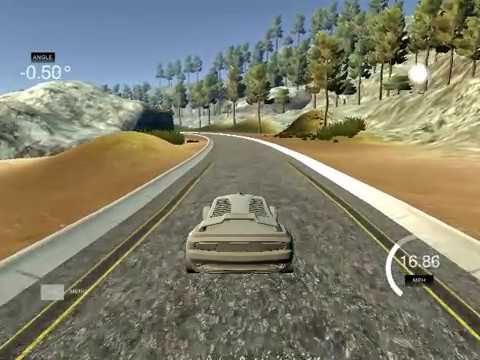

In [49]:
YouTubeVideo("ALLuQNLj-Ys")

### 2.2 Track 2   

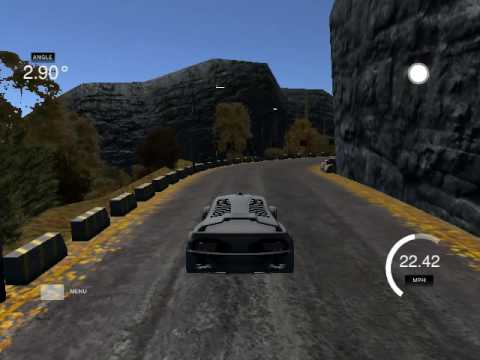

In [50]:
YouTubeVideo("W4BEJ9_38QA")

## 3. Hardware/Software Setup

MSI GT62VR Dominator Pro Laptop, 32 GB DDR4 2400 RAM, Intel i7, 1 TB HDD + 256 SSD     
Nvidia GTX 1070 8 GB GDDR5, 1920 CUDA cores    
Ubuntu 16.10   
TensorFlow 0.12.0-rc0   

## 4. Autonomous Driving Car Pipeline

The schematic depiction of autonomous car driving pipeline is presented. Image frames from cameras are extracted, preprocessed and then passed through the image-processing pipeline. The processed images are subsequently passed through the biased data generator. A convolutional neural network (CNN) is trained to predict a steering angle for driving. The detail of each processing sub stage is presented in the subsequent sections.  

<table>
<tr>
    <td>
        <img src='images/ImageProcessing_CNN_Pipeline.png' style="width: 800px;">
    </td>
</tr>
</table>

## 5. Data Source/Augmentation/Generator

### 5.1 Data Source

The data is obtained from by manually(human) driving a car on a track in Udacity's Self-Driving Car Simulator. Initially, I obtained data by manually driving a car on Track 1 for few laps and recovering from mistakes. Later, for this project, I used the data provided by Udacity. 

The data consists of `center camera, left camera, right camera` images and corresponding `steering, throttle, brake, speed` variables extracted at 10 Hz. The three camera images and corresponding variables are extracted and stacked in a data frame. 

The steering angle is plotted for a full lap on Track 1 (left image). The plot shows steering angles with sharp turns indicated by big spikes. The histogram (with 20 bins) presents the frequency of steering angles (right image). The plot indicates that the steering angle near `0` (i.e. driving straight) is more prominent on the track than sharp turns with `-0.9` or `0.9`. This imbalance of steering angle would train any model to drive a car in a straight line, if fed with random sampled data. To alleviate this issue, a biased data is fed for the training. The details are discussed in following sections.  

<table>
<tr>
    <td>
        <img src='images/steeringangles.png' style="width: 480px;">
    </td>
    <td>
        <img src='images/steeringangles_hist.png' style="width: 480px;">
    </td>
</tr>
</table>

### 5.2 Data Pre-Processing

A constant steering angle offset is added to the left and right camera to account for matching center camera data. A steering offset of `0.25` is added to the left camera steering angle and subtracted from the camera right  steering angle. This is because the left camera has to move right with an offset to come to the center. Conversely, the right camera has to move left with an offset to come to the center. An estimate of offset is obtained from Slack/Confluence discussions.  

````
def read_csv_df(directory, fname_log_file):
	"""
	Read CSV file in Pandas Dataframe
	:param directory: Directory where log file is saved
	:param fname_log_file: log file name
	:return:
	    pandas dataframe with stacked
	"""
	df = pd.read_csv(directory + fname_log_file)  # , names=columns)

	# Stack center, left and right images in dataframe
	dfc = df[['center', 'steering']]
	dfc['camera'] = 'c'
	dfc.rename(columns={'center': 'image'}, inplace=True)

	dfl = df[['left', 'steering']]
	dfl['steering'] += offset
	dfl['camera'] = 'l'
	dfl.rename(columns={'left': 'image'}, inplace=True)

	dfr = df[['right', 'steering']]
	dfr['steering'] = dfr['steering'] - offset
	dfr['camera'] = 'r'
	dfr.rename(columns={'right': 'image'}, inplace=True)

	frames = [dfc, dfl, dfr]
	dfn = pd.concat(frames)

	dfn = dfn.loc[np.abs(dfn['steering']) <= 1.0]
	dfn = dfn.reset_index(drop=True)
	return dfn
````

### 5.3 Data Augmentation

In the early phases of the project, I directly fed the images to CNN to train. Soon, it became apparent that a better image processing pipeline is required. Following the conversations on Confluence/Slack community, a data augmentation pipeline is developed. Medium posts from John/Vivek/Mohan were immensely useful. 

The data augmentation is conducted via image processing pipeline to generate more data and add new conditions. The pipeline (refer to the schematic in Section 4) consists of following transformations:  

#### 5.3.1 Randomly translate image in X and Y directions

The image is picked randomly from `center, left` or `right` camera and randomly translated in X and Y directions. A steering offset is added to account for X-translation. The Y-translation is added to account for elevation of road track.  

#### 5.3.2 Randomly change brightness of an image

Udacity has provided a rich simulator accounting for different lighting conditions on two tracks. A quick browsing through different graphics quality (fastest vs Beautiful/Fantastic) reveals tracks with different lighting/shadow conditions. As mentioned earlier, the DL model is trained for track 1 and does not see track 2, which has dark lighting conditions. 

In order to recreate lighting conditions, brightness of an image is randomly changed via the conversion:   
**`RGB image -> YUV image -> randomly change V channel value -> RGB image.`**   
With the above transformations, the model can drive on track 2. This transformation is inspired by Vivek's Medium post.  

#### 5.3.3 Crop image to remove rows with sky and bonnet pixels

The camera images consist of extra information such as pixels from sky and car bonnet. These pixels are not important to drive a car on the road. The top 60 pixel rows consisting of sky and bottom 20 rows consisting of a car bonnet are removed from 160x320x3 image. The cropped image is used for further transformations.  

#### 5.3.4 Resize image to desired shape

The cropped image is resized to 40x80x3 in order to train model faster. 

#### 5.3.5 Randomly flip image and modify the steering angle

At the last stage, an image is randomly flipped vertically. The steering angle of a flipped image is modified by multiplying it with `-1`.

~~~~
# Snippet to read batch data with augmentation 

def read_batchdata(df,
                   bright=0,
                   brightness_perc=0.25,
                   crop=1,
                   resize=1,
                   resize_height=40,
                   resize_width=80,
                   normalize=0,
                   flip=0):
	"""
	Split Data - Train/Valid dataset
	:param df: data frame
	:param bright: binary value to augment brigtness in an image
	:param brightness_perc: fraction of brightness_percentage
	:param crop: binary value to crop an image
	:param resize: binary value to resize an image
	:param resize_height: # resized pixels in height
	:param resize_width: # resized pixels in width
	:param normalize: binary value to augment normalize an image
	:param flip: binary value to flip an image
	:return:
	    batch of images and steering angles
	"""

	# read images
	imgs = df['image'].values
	steering = df['steering'].values
	x_translation = df['x_translation'].values

	cv_img = []
	steeringn = []

	img = cv2.imread(imgs[0].strip())
	(rows, cols, channels) = img.shape

	# Read camera images in numpy array
	i = 0
	for img in imgs:

		# read image
		img = cv2.imread(img.strip())

		# translate image in X and Y direction
		tr_x = x_translation[i]
		tr_y = (TRANS_Y_RANGE * np.random.uniform()) - (TRANS_Y_RANGE / 2)
		trans_m = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
		img = cv2.warpAffine(img, trans_m, (cols, rows))

		# augment brightness
		if bright == 1:
			imgtemp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
			random_bright = brightness_perc + np.random.uniform()
			imgtemp[:, :, 2] = imgtemp[:, :, 2] * random_bright
			img = cv2.cvtColor(imgtemp, cv2.COLOR_HSV2RGB)

		# crop Images
		if crop == 1:
			img = img[60:140, :, :]

		# Resize images
		if resize == 1:
			img = cv2.resize(img, (resize_width, resize_height))  # , interpolation=cv2.INTER_AREA)

		# normalize images
		if normalize == 1:
			img = (img / 127.5 - 1.0)

		# flip image
		if flip == 1:
			if np.random.randint(2) == 0:  # Flip the image
				img = np.asarray(cv2.flip(img, 1))
				steeringn.append(-steering[i])
			else:
				steeringn.append(steering[i])
		else:
			steeringn.append(steering[i])

		cv_img.append(img)
		i += 1

	imgs = np.asarray(cv_img).astype('uint8')

	return imgs, np.asarray(steeringn)

~~~~

Sample original images and augmented images are presented below.

<table>
<tr>
    <td style="text-align: center;">
        Original Image (160x320x3)
    </td>
    <td style="text-align: center;">
        Augmented Image (40x80x3, not to scale)
    </td>
</tr>
<tr>
    <td style="text-align: center;">
        <img src='images/original0.png' style="width: 300px;">
    </td>
    <td style="text-align: center;">
        <img src='images/augmented0.png' style="width: 200px;">
    </td>
</tr>
<tr>
    <td style="text-align: center;">
        <img src='images/original1.png' style="width: 300px;">
    </td>
    <td>
        <img src='images/augmented1.png' style="width: 200px;">
    </td>
</tr>
<tr>
    <td style="text-align: center;">
        <img src='images/original2.png' style="width: 300px;">
    </td>
    <td>
        <img src='images/augmented2.png' style="width: 200px;">
    </td>
</tr>
<tr>
    <td style="text-align: center;">
        <img src='images/original3.png' style="width: 300px;">
    </td>
    <td>
        <img src='images/augmented3.png' style="width: 200px;">
    </td>
</tr>
</table>

### 4.3 Data Generator

As discussed in Section 5.1, steering angles near `0` are more prominent than sharp left/right turns. The imbalance of steering angles can cause the model to train and drive a car in straight line. In order to expose and train model to low frequency steering angles such as sharp left/right turn, the model needs to be fed with biased data. The following figure explains the effect of biasing the data. The data for `bias = 1` promotes driving a car in a straight line. As the bias approaches `0`, the function promotes non-zero steering angles with more left/right turns. The training is started by setting bias = 1 and gradually decreasing it to near zero. 
This idea is inspired by Vivek/Mohan's Medium post.   

<table>
<tr>
    <td style="text-align: center;">
        bias = 1.0
    </td>
    <td style="text-align: center;">
        bias = 0.5
    </td>
    <td style="text-align: center;">
        bias = 0.0
    </td>
</tr>
<tr>
    <td>
        <img src='images/bias512_1.png' style="width: 350px;">
    </td>
    <td>
        <img src='images/bias512_0p5.png' style="width: 350px;">
    </td>
    <td>
        <img src='images/bias512_0.png' style="width: 350px;">
    </td>
</tr>
</table>

~~~~
# Snippet to sample biased batch data
def biased_batch_data(df, batch_size, bias):
	"""
	Read CSV file in Pandas Dataframe
	:param df: data frame
	:param samples: batch sample size in integer
	:return:
	    sampled pandas dataframe with stacked
	"""

	# pick data equally from c, l and r images
	nbatches = 4

	dfsamples = shuffle(sample_df(df, samples=nbatches * batch_size))
	dftemp = pd.DataFrame(columns=['image', 'steering', 'camera', 'x_translation'])

	for index, row in dfsamples.iterrows():
		x_translation = (TRANS_X_RANGE * np.random.uniform()) - (TRANS_X_RANGE / 2)
		new_angle = row['steering'] + ((x_translation / TRANS_X_RANGE) * 2) * TRANS_ANGLE

		row['steering'] = new_angle
		row['x_translation'] = x_translation

		threshold = np.random.uniform()
		if ((abs(new_angle) + bias) > threshold):
			dftemp.loc[len(dftemp.index)] = row
			if len(dftemp.index) > batch_size + 50:
				break

	dftemp = dftemp.loc[np.abs(dftemp['steering']) <= 1.0]
	dftemp = dftemp.sample(batch_size)

	return dftemp
~~~~

In general, the image data is huge in size and overflows a general-purpose CPU memory. In order to perform computations, it is advisable to generate a small data batch on the fly. This is achieved using the data generator in Keras API. The following snippet reads a data frame and produces images and steering angle in a desired batch size.  
 

~~~~
# Snippet of data generator function
def data_generator(df, batch_size, bias):
	"""
	Read batch data using the generator
	:param df: data frame
	:param batch_size: batch size in integer
	:param bias: bias value to select right/left turn steering angles
	:return:
	    batch images and steering angles
	"""

	total_batch = int(len(df.index) / batch_size)
	while True:
		for i in range(total_batch):
			# sample bias batch data
			datadf = biased_batch_data(df, batch_size, bias)

			# read batch images and labels
			batch_images, batch_labels = read_batchdata(datadf,
			                                            bright,
			                                            brightness_perc,
			                                            crop,
			                                            resize,
			                                            resize_height,
			                                            resize_width,
			                                            normalize,
			                                            flip=1)

			yield (batch_images, batch_labels)
~~~~

### 4.4 Data Feed

For training the DL model, a small batch of `512` augmented images and steering angles are provided. The data is split into training and validation dataset in a ratio of 80:20. There is no test dataset used for this model. Rather, the model is tested on autonomous tracks 1 and 2.   


~~~~
def train_valid_test_split(df, random_state=0, size_train=0.8, size_valid=0.2):
	"""
	Split Data - Train/Valid dataset
	:param df: data frame
	:param random_state: random state seed value
	:param size_train: fraction of training sample
	:param size_valid: fraction of validation sample
	:return:
	    training and validation dataset
	"""

	df_train, df_valid = train_test_split(df, test_size=size_valid, random_state=random_state)

	return df_train, df_valid
~~~~

## 5. Deep Learning Model

### 5.1 Convolutional Neural Network

Initially, I started with Nvidia's self-driving car and custom convolutional neural network (CNN) architectures. However, after few iterations, I settled on the comma.ai CNN architecture with a modification in #kernels. The schematic of convolutional neural network (CNN) is presented in Section 4. The CNN has following layers:  

<table>
<tr>
    <td style="text-align: center;">
        **Layer**
    </td>
    <td style="text-align: center;">
        **Description**
    </td>
    <td style="text-align: center;">
        **Purpose**
    </td>
</tr>
<tr>
    <td>
        Lambda
    </td>
    <td>
        Normalize data
    </td>
    <td>
        Normalizes image data in `-1` and `1`. This is particularly useful trick for numerical stability and convergence.
    </td>
</tr>
<tr>
    <td>
        Convolution Layer 1
    </td>
    <td>
        32 kernels of 3x3 size, stride 2x2, ELU activation
    </td>
    <td>
        Convolution layer to extract features.
    </td>
</tr>
<tr>
    <td>
        Convolution Layer 2
    </td>
    <td>
        64 kernels of 3x3 size, stride 2x2, ELU activation
    </td>
    <td>
        Convolution layer to extract features.
    </td>
</tr>
<tr>
    <td>
        Maximum Pooling
    </td>
    <td>
        size 2x2
    </td>
    <td>
        Downsample an image.
    </td>
</tr>
<tr>
    <td>
        Convolution Layer 3
    </td>
    <td>
        128 kernels of 3x3 size, stride 2x2, ELU activation
    </td>
    <td>
        Convolution layer to extract features.
    </td>
</tr>
<tr>
    <td>
        Flatten
    </td>
    <td>
        Dropout 0.5, ELU activation
    </td>
    <td>
        Flatten `2D` image to `1D`. Dropout for regularization and avoiding overfitting.
    </td>
</tr>
<tr>
    <td>
        Dense 
    </td>
    <td>
        512 nodes, Dropout 0.5, ELU activation
    </td>
    <td>
        Neural network with dropout to avoid overfitting.
    </td>
</tr>
<tr>
    <td>
        Dense 
    </td>
    <td>
        1 node
    </td>
    <td>
        Steering angle output as a regression value.
    </td>
</tr>
</table>

Exponential Linear Unit (ELU) is chosen as an activation function over rectified linear units (ReLU) in order to avoid a vanishing gradient problem and achieve faster learning [[Paper](https://arxiv.org/abs/1511.07289)]. Dropout is used for regularization after flattening layer and first dense layer. The details about the layers, output shape, #paramerers and connection are presented in the following summary.

<table>
<tr>
    <td>
        <img src='images/cnn_architecture.png' style="width: 800px;">
    </td>
</tr>
</table>

As a regression problem, the `mean squared error (mse)` is chosen as a loss function. The `Adam` optimizer is used to train the model.   
A parametric study is conducted to choose appropriate `batch size`,  `number of epochs`,  `learning rate` and `dropout` values. The values used to train the model are as  follows: 

<table>
<tr>
    <td>
        **Batch Size**
    </td>
    <td>
        512
    </td>
</tr>
<tr>
    <td>
        **# Epochs**
    </td>
    <td>
        10
    </td>
</tr>
<tr>
    <td>
        **Learning Rate**
    </td>
    <td>
        0.001
    </td>
</tr>
<tr>
    <td>
        **Dropout**
    </td>
    <td>
        0.5
    </td>
</tr>
</table>

### 5.2 Model Training/Validation

The model is trained with biased data to learn left/right steering. The snippet of the training model is presented below. The model is trained for 10 epochs with bias gradually decreasing from `1` to near-zero. The training and validation losses are plotted, and model weights are saved after each epoch.  

~~~~
# Snippet to train model using data generator
	while True:
		bias = 1.0 / (num_runs + 1.0)

		print('\nRun {} with bias {}'.format(num_runs + 1, bias), end=': ')

		history = model.fit_generator(
			data_generator(df_train, FLAGS.batch_size, bias),
			samples_per_epoch=len(df_train.index),
			nb_epoch=1,
			validation_data=data_generator(df_valid, FLAGS.batch_size, bias=1),
			nb_val_samples=len(df_valid.index),
			verbose=1
		)

		# Save the model and the weights
		serialize_model_weights(model, FLAGS.fname_model + str(num_runs))

		# append history loss
		history_loss.append(history.history['loss'][0])
		history_vloss.append(history.history['val_loss'][0])

		num_runs += 1

		# Terminate epoch
		if num_runs > FLAGS.nb_epoch:
			break
~~~~            

## 6. Results

The MSE losses for training and validation data are presented below (left image). Both the losses have decreasing trend. The error in steering angle (actual - prediction) angle is presented for sample 500 images (right image). The average error is contained in a small band near `0`.

<table>
<tr>
    <td style="text-align: center;">
        **MSE Loss**
    </td>
    <td style="text-align: center;">
        **Sample Validation error (actual - prediction) steering angle**
    </td>
</tr>
<tr>
    <td>
        <img src='images/model_loss.png' style="width: 450px;">
    </td>
    <td>
        <img src='images/model_valid_error_500.png' style="width: 450px;">
    </td>
</tr>
</table>

The saved model is then used to drive a car autonomously on Tracks 1 and 2 as presented in the videos in Section 2.

## 7. Conclusions

A human driving behavior cloning model is successfully developed to autonomously drive a car in a simulator. The camera image data is augmented and fed to a CNN model. The model is trained on Track 1. The model drives a car on Track 1 in an autonomous mode continuously. The model does surprisingly well on Track 2, although it never saw Track 2 data during training.  

## 8. Future work

* Develop a new DL model (similar to Nvidia's SDC) which reads the left/center/right camera image data simultaneously and implements CNN and followed by merge, flatten and dense layers. 
* Adding running steering angle smoothing code to avoid sudden jumps in steering angle.
* Better graphics quality data from the Udacity simulator offer track data with varying lighting conditions. Robust model can be trained for distinct scenarios for different quality data. 
* Check how the model performs in real-world scenarios.  

## 9. Refelections

What a project! What a journey! What an incredible experience!   

This is one of the tough projects I worked on. Probably, the biggest take away and learning for me is how to feed the imbalance (class) data to a model for training. Prior, I spent two weeks tuning and training the model with no success. After reading Vivek/Mohan's Medium post, it became clear to me the importance of slowly feeding the biased data to a model and train it to predict low frequency data (class). 
In addition, the project wouldn't have been completed without implementing tips and tricks shared on Slack/Confluence by aspiring Self-Driving Car Engineers colleagues in the Udacity's Nanodegree program. 

## Acknowledgements

*  [Nvidia's Paper: End to End Learning for Self-Driving Cars](https://arxiv.org/abs/1604.07316)  
*  [Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)](https://arxiv.org/abs/1511.07289)
*  [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
*  [Comma AI CNN model](https://github.com/commaai/research/blob/master/view_steering_model.py)
*  [Vivek's Medium Post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.kw4hdzc0z)
*  [Mohan's Medium Post](https://medium.com/@vivek.yadav/cloning-a-car-to-mimic-human-driving-using-pretrained-vgg-networks-ac5c1f0e5076#.92c970gjk)
*  [John Chen's Agile Trainer](https://github.com/diyjac/AgileTrainer)
*  [Thomas's Live Trainer](https://github.com/thomasantony/sdc-live-trainer)
*  Udacity's Self Driving Car Nanodegree Slack/Confluence 

<table>
<tr>
    <td>
        <iframe width="420" height="315"
            src="https://youtu.be/ALLuQNLj-Ys">
        </iframe>
    </td>
</tr>
<tr>
    <td align="center">
        bias = 1.0
    </td>
    <td align="center">
        bias = 0.5
    </td>
</tr>
</table>

In [53]:
HTML("""
<video width="680" height="320" controls loop>
  <source src="images/Track1_B512_FullLap.mp4" type="video/mp4">
</video>
""")

In [29]:
HTML("""
<video width="680" height="320" controls loop>
  <source src="images/Track2_B512_FullLap.mp4" type="video/mp4">
</video>
""")